## A/B тестирование.  АА тест на корректность системы сплитования.

Имеются данные АА-теста с '2022-01-24' по '2023-01-30'.
Необходимо сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

### Вывод
__Мы получили 4.8 % значений p-value меньше или равно 0.05 и равномерное распределение значений p_value.
Исходя из получившихся результатов, мы принимаем нулевую гипотезу об идентичности групп 2 и 3. Наша система сплитования работает корректно.__ 

__Формируем гипотезы:__

Н0 = Различий между группами нет, система сплитования работает корректно.

Н1 = Различия между группами есть, система сплитования работает не корректно.

In [1]:
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
sns.set(
    rc={
        "figure.figsize": (12, 8), #размер графика - 12 дюймов в ширину, 8 в длину
        "axes.titlesize": 20, #размер заголовка 
        "axes.labelsize": 14, #размер подписей осей
        "xtick.labelsize": 13, #размер подписей чёрточек на x-оси
        "ytick.labelsize": 13, #размер подписей чёрточек на y-оси
    }
)

In [3]:

connection = {'host': ,
                      'database':,
                      'user':, 
                      'password':
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-24' and '2023-01-30'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,2,131473,26,148,0.175676
2,3,123580,15,92,0.163043
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


Посмотрим общее описание по каждой группе

In [7]:
df[df.exp_group == 2].describe()

,exp_group,user_id,likes,views,ctr
count,8480.0,8480.000000,8480.000000,8480.000000,8480.000000
mean,2.0,69282.766981,15.534198,73.493868,0.218246
std,0.0,53428.421103,10.814642,48.332066,0.080643
min,2.0,218.000000,0.000000,1.000000,0.000000
25%,2.0,16156.750000,7.000000,36.000000,0.164451
50%,2.0,107779.500000,13.000000,64.000000,0.205882
75%,2.0,121660.000000,21.000000,100.000000,0.260870
max,2.0,133642.000000,83.000000,364.000000,0.714286


In [9]:
df[df.exp_group == 3].describe()

,exp_group,user_id,likes,views,ctr
count,8569.0,8569.000000,8569.000000,8569.000000,8569.000000
mean,3.0,69522.305520,15.612790,74.097678,0.219161
std,0.0,53281.229624,10.663215,49.081302,0.080932
min,3.0,200.000000,0.000000,2.000000,0.000000
25%,3.0,16332.000000,8.000000,36.000000,0.166667
50%,3.0,108007.000000,13.000000,64.000000,0.206612
75%,3.0,121563.000000,21.000000,102.000000,0.261538
max,3.0,133635.000000,83.000000,369.000000,0.714286


Количество пользователей в группах почти одинаковое, отличается на 1%. Средние значения CTR отличаются на 0.001

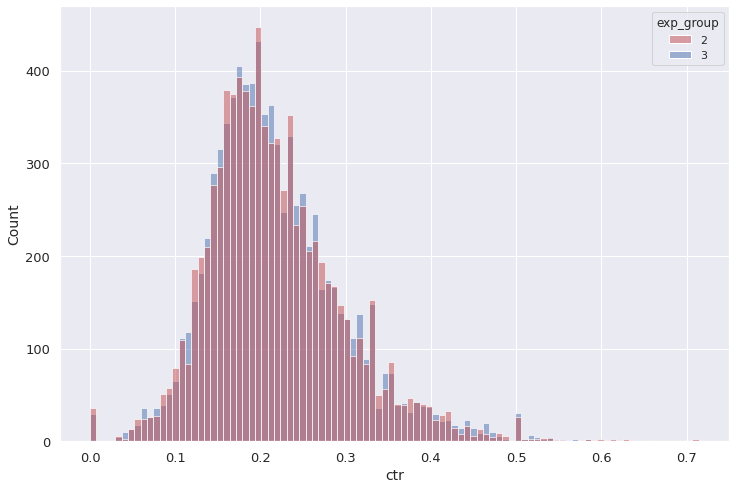

In [5]:
#посмотрим визуально распределение ctr в наших группах
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Визуально группы почти не отличаются 

Для начала проведём сравнение t-тестом целых выборок группы 2 и 3.

In [6]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

p-value t-теста  по целым группам больше 0.05. Похоже что между CTR групп 2 и 3  нет статистически значимых отличий. 

__Теперь проведём  симуляцию 10000 АА-тестов__

In [23]:
# Создадим вспомогательную функцию
def simulation (df1, df2, n_users, n_tests):
    """
    Данная вспомогательная функция принимает 2 серии параметров сравнимаемых групп,
    количество пользователей в подвыборке и количество проводимых тестов.

    Параметры
    ---------
    df1, df2: серии параметров групп
    n_users: количество пользователей в подвыборке
    n_tests: количество проводимых t-тестов
        
    Функция возвращает серию из n_tests значений p-value
    """
    p_value = []
    for i in range(n_tests):
        sample_1 = df1.sample(n_users, replace=False)
        sample_2 = df2.sample(n_users, replace=False)
        t_test = stats.ttest_ind(sample_1, sample_2, equal_var=False)
        p_value.append(t_test[1])
    return p_value
    

In [24]:
p_value = simulation(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr, 500, 10000)

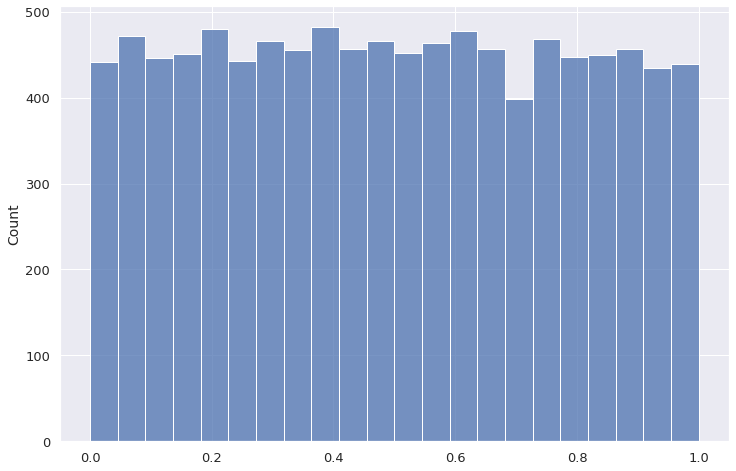

In [25]:
#строим гистограмму распределения получившихся p_value
sns.histplot(p_value)
plt.show()

Похоже на равномерное распределение

In [26]:
#Посчитаем долю значений больше 0.05 в получившихся p_value
a = 0 #количество p_value < 0.05
for i in p_value:
    if i<= 0.05:
        a += 1
rate = a*100 / len(p_value)
print(f'{rate} % значений p-value меньше или равно 0.05' )       


4.8 % значений p-value меньше или равно 0.05


### Вывод
__Мы получили 4.8 % значений p-value меньше или равно 0.05 и равномерное распределение значений p_value.
Исходя из получившихся результатов, мы принимаем нулевую гипотезу об идентичности групп 2 и 3. Наша система сплитования работает корректно.__ 